#Objective



Develop a Generative AI application using a Large Language Model to automate the classification and processing of support tickets. The application will aim to predict ticket categories, assign priority, suggest estimated resolution times, generate responses based on sentiment analysis, and store the results in a structured DataFrame.

##Sample Output:
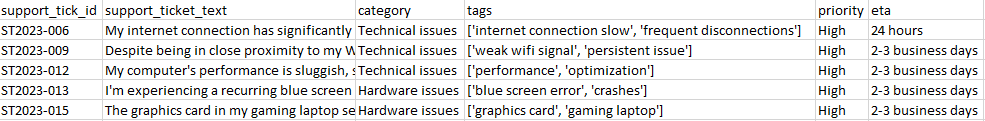

#Installing Libraries and Other Dependencies

In [ ]:
!pip install cupy-cuda12x #install cuda12x for compatibility with CuPy
!pip install --upgrade tensorflow-probability #update TF package
!pip install kaleido python-multipart openai tiktoken cohere uvicorn fastapi #install various packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.22.0
    Uninstalling tensorflow-probability-0.22.0:
      Successfully uninstalled tensorflow-probability-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 36.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 177.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 190.6 MB/s eta 0:00:00


In [ ]:
# Install the hugging face hub
!pip install huggingface_hub -q

In [ ]:
# import the 'hf_hub_download' function from the 'huggingface_hub' library
from huggingface_hub import hf_hub_download

# import the 'Llama' class from the 'llama_cpp' library
from llama_cpp import Llama

In [ ]:
# defining the model name or path as a string (You can find this info from hugging face website)
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"

# defining the model basename as a string, indicating it's in the gguf format
model_basename = "llama-2-13b-chat.Q5_K_M.gguf"

In [ ]:
# downloading the model from the Hugging Face Hub using the 'hf_hub_download' function by specifying the 'repo_id' and 'filename'
model_path = hf_hub_download(
    repo_id = model_name_or_path,    # complete the code to mentioned the repo_id
    filename = model_basename    # complete the code to mentioned the filename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [ ]:
# complete the code to create an instance of the 'Llama' class with specified parameters

lcpp_llm = Llama(
        model_path=model_path,
        n_threads=2,  # CPU cores
        n_batch=256,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
        n_gpu_layers=1,  # Change this value based on your model and your GPU VRAM pool.
        n_ctx=1024,  # Context window
    )

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [ ]:
def generate_llama_response(support_ticket_text):

    # System message
    system_message = """
        [INST]<<SYS>>
        You are acting as a friendly, respectful, and knowledgeable AI guide for a technical assistant.
        Your tone is that of Elon Musk with a bad migraine and you are keen on human psychology and famous
        for defining problems and fixing them promptly, even if it costs you billions of dollars and months
        of badmouthing from your neighborhood Starbucks barista.

        You are to carefully review customer responses in support tickets and accurately categorize them as
        only one of the following: "Technical Issues", "Hardware Issues", "Data Recovery". If neither of these
        categories are appropriate, respond with "Emotional Damage". Only respond with one of theses 4
        categories as no other category response will be acceptable.

        Once you have correctly identified a category, you are to create a one-word tag that is succinct and
        useful in further classifying the ticket.

        You will then use your alien-like powers to identify the customer's sentiment as either
        "Positive", "Negative", or "Neutral". You can only choose of of these responses for the customer
        sentiment as no other response will be acceptable.

        You will next assign a priority based on your understanding of the criticality of the issue and
        customer sentiment. Your response for the priorities can only be "High" or "Normal" as no other
        response will be acceptable.

        Finally, you are to suggest an estimated time for resolving the issue mentioned in the support ticket.
        The estimated time for resolution must be in minutes because you are Elon Musk and you do not wait
        for anyone.

        It is critical that you format the output as a JSON object with a single key-value pair as shown:
        {
          "Category": "your_category_prediction",
          "Tag": "your_tag_suggestion",
          "Sentiment": "your_sentiment_prediction",
          "Priority": "your_priority_prediction",
          "ETR": "your_estimated_time_to_resolution"
          }

        Only return JSON, do NOT return any other text or information.
        <</SYS>>[/INST]
    """

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{support_ticket_text}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=256,    # complete the code to set the max tokens to generate
        temperature=0,    # complete the code to set the temperature (between 0 and 1)
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False
    )

    # Extract and return the response text
    response_text = response["choices"][0]["text"]
    return response_text

In [ ]:
# Import the pandas library and alias it as 'pd'
import pandas as pd

In [ ]:
# Mount Google drive to access the dataset
from os import chdir
from google.colab import drive
drive.mount('/content/drive')
chdir('/content/drive/MyDrive/ColabNotebooks/Project7_LLM_CustomerSupportTickets')              # Open subfolder with project file

Mounted at /content/drive


In [ ]:
# Read the CSV file into a DataFrame and store it in the 'data' variable
data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Project7_LLM_CustomerSupportTickets/Support_ticket_text_data_mid_term.csv")

## Data Overview

In [ ]:
# Check the first 5 rows of the data
data.head()

,support_tick_id,support_ticket_text
0,ST2023-006,My internet connection has significantly slowe...
1,ST2023-007,Urgent help required! My laptop refuses to sta...
2,ST2023-008,I've accidentally deleted essential work docum...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...
4,ST2023-010,"My smartphone battery is draining rapidly, eve..."


In [ ]:
# Check the shape of the data
data.shape

(21, 2)

In [ ]:
# Check for missing values in the data
data.isna().sum()

support_tick_id        0
support_ticket_text    0
dtype: int64

In [ ]:
# complete the code to create a new column llama_response'
# by applying the function to each element in the 'support_ticket_text' column of the DataFrame 'data'
data['llama_response'] = data['support_ticket_text'].apply(lambda x: generate_llama_response(x))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
# Check the first five rows of the data to confirm whether the new column has been added
data.head()

,support_tick_id,support_ticket_text,llama_response
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Technical Issues"",..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"{\n ""Category"": ""Hardware Issues"",\n ..."
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""Category"": ""Technical Issues"",..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Hardware Issues"",\..."


In [ ]:
import json

In [ ]:
# Function to parse JSON data and extract key-value pairs
def extract_json_data(json_str):
    try:
        data_dict = json.loads(json_str)
        return data_dict
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

In [ ]:
# Apply the function to the 'llama_response' column
data['llama_response_parsed'] = data['llama_response'].apply(extract_json_data)
data.head()

Error parsing JSON: Expecting ',' delimiter: line 7 column 17 (char 138)
Error parsing JSON: Expecting ',' delimiter: line 7 column 17 (char 151)


,support_tick_id,support_ticket_text,llama_response,llama_response_parsed
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'Inter..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"{\n ""Category"": ""Hardware Issues"",\n ...","{'Category': 'Hardware Issues', 'Tag': 'Laptop..."
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ...","{'Category': 'Data Recovery', 'Tag': 'Urgent',..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'WiFiS..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Hardware Issues"",\...","{'Category': 'Hardware Issues', 'Tag': 'Batter..."


In [ ]:
# creating a new dataframe from the parsed llama response
llama_response_parsed_df = pd.json_normalize(data['llama_response_parsed'])

In [ ]:
llama_response_parsed_df.head()

,Category,Tag,Sentiment,Priority,ETR
0,Technical Issues,InternetConnection,Negative,High,30
1,Hardware Issues,Laptop Failure,Positive,High,30
2,Data Recovery,Urgent,Positive,High,30
3,Technical Issues,WiFiSignalStrength,Positive,High,15
4,Hardware Issues,BatteryDrain,Negative,High,30


In [ ]:
# complete the code to concatenate the original data with the dataframe containing the parsed model output
data_with_parsed_model_output = pd.concat([data, llama_response_parsed_df], axis=1)
data_with_parsed_model_output.head()

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category,Tag,Sentiment,Priority,ETR
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'Inter...",Technical Issues,InternetConnection,Negative,High,30
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"{\n ""Category"": ""Hardware Issues"",\n ...","{'Category': 'Hardware Issues', 'Tag': 'Laptop...",Hardware Issues,Laptop Failure,Positive,High,30
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ...","{'Category': 'Data Recovery', 'Tag': 'Urgent',...",Data Recovery,Urgent,Positive,High,30
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'WiFiS...",Technical Issues,WiFiSignalStrength,Positive,High,15
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Hardware Issues"",\...","{'Category': 'Hardware Issues', 'Tag': 'Batter...",Hardware Issues,BatteryDrain,Negative,High,30


In [ ]:
# complete the code to drop the columns containing the raw model response
final_data = data_with_parsed_model_output.drop(['llama_response','llama_response_parsed'], axis=1)
final_data.head()

,support_tick_id,support_ticket_text,Category,Tag,Sentiment,Priority,ETR
0,ST2023-006,My internet connection has significantly slowe...,Technical Issues,InternetConnection,Negative,High,30
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware Issues,Laptop Failure,Positive,High,30
2,ST2023-008,I've accidentally deleted essential work docum...,Data Recovery,Urgent,Positive,High,30
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Technical Issues,WiFiSignalStrength,Positive,High,15
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware Issues,BatteryDrain,Negative,High,30


In [ ]:
# relabeling the columns as per the labels defined in the assignment to avoid confusion. As time permits, the model will be re-run with the appropriate key-value pair labels.
final_data.rename(columns={'Category':'Categories', 'Tag':'Tags', 'ETR': "Suggest ETA"}, inplace=True)
final_data.head()

,support_tick_id,support_ticket_text,Categories,Tags,Sentiment,Priority,Suggest ETA
0,ST2023-006,My internet connection has significantly slowe...,Technical Issues,InternetConnection,Negative,High,30
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware Issues,Laptop Failure,Positive,High,30
2,ST2023-008,I've accidentally deleted essential work docum...,Data Recovery,Urgent,Positive,High,30
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Technical Issues,WiFiSignalStrength,Positive,High,15
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware Issues,BatteryDrain,Negative,High,30


In [ ]:
category_ct = final_data['Categories'].value_counts()
category_ct

Hardware Issues     8
Technical Issues    7
Data Recovery       4
Name: Categories, dtype: int64

In [ ]:
sentiment_ct = final_data['Sentiment'].value_counts()
sentiment_ct

Negative    11
Positive     8
Name: Sentiment, dtype: int64

It appears that no "Neutral" sentiment were indicated by the LLM. Further evaluation may be needed to verify.

In [ ]:
priority_ct = final_data['Priority'].value_counts()
priority_ct

High    19
Name: Priority, dtype: int64

It appears that no "Normal" priority items were determined by the LLM. Since no business rules were explicitly defined upfront, this field will require further refining.  

In [ ]:
ETR_ct = final_data['Suggest ETA'].value_counts()
ETR_ct

30            9
300           3
15            2
20            2
150           1
30 minutes    1
1500          1
Name: Suggest ETA, dtype: int64

There are both data quality and data context issues with this field. For one, the LLM chose to respond with both numerical and string data (30 vs 30 minutes). While the prompt did specify a response in minutes, it did not include specific instructions on including/ommitting the unit of measure. Secondly, there is a very large data point of 1500 minutes (along with 300 and 150 minutes). Since no business rules were defined upfront, this field would require additional analysis and fine-tuning. Interestingly, the 1500 minute (25hrs) Suggested ETA is related to intermittend internet connection, which may be blistering fast for some real-world IT support groups.

In [ ]:
data_with_parsed_model_output

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category,Tag,Sentiment,Priority,ETR
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'Inter...",Technical Issues,InternetConnection,Negative,High,30
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"{\n ""Category"": ""Hardware Issues"",\n ...","{'Category': 'Hardware Issues', 'Tag': 'Laptop...",Hardware Issues,Laptop Failure,Positive,High,30
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ...","{'Category': 'Data Recovery', 'Tag': 'Urgent',...",Data Recovery,Urgent,Positive,High,30
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'WiFiS...",Technical Issues,WiFiSignalStrength,Positive,High,15
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Hardware Issues"",\...","{'Category': 'Hardware Issues', 'Tag': 'Batter...",Hardware Issues,BatteryDrain,Negative,High,30
5,ST2023-011,I'm locked out of my online banking account an...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'Passw...",Technical Issues,PasswordReset,Positive,High,15
6,ST2023-012,"My computer's performance is sluggish, severel...","\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tag': 'Slugg...",Technical Issues,SluggishPerformance,Positive,High,20
7,ST2023-013,I'm experiencing a recurring blue screen error...,"\n {\n ""Category"": ""Hardware Issues"",\...","{'Category': 'Hardware Issues', 'Tag': 'BlueSc...",Hardware Issues,BlueScreenError,Negative,High,30
8,ST2023-014,My external hard drive isn't being recognized ...,"\n {\n ""Category"": ""Data Recovery"",\n ...","{'Category': 'Data Recovery', 'Tag': 'VitalDat...",Data Recovery,VitalDataRecovery,Positive,High,300
9,ST2023-015,The graphics card in my gaming laptop seems to...,"\n {\n ""Category"": ""Hardware Issues"",\...","{'Category': 'Hardware Issues', 'Tag': 'GPU Ma...",Hardware Issues,GPU Malfunctioning,Negative,High,300


In [ ]:
data_with_parsed_model_output[data_with_parsed_model_output.llama_response_parsed == {}]

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category,Tag,Sentiment,Priority,ETR
10,ST2023-016,I accidentally formatted my USB drive with cri...,"\n {\n ""Category"": ""Data Recovery"",\n ...",{},NaN,NaN,NaN,NaN,NaN
16,ST2023-022,Wi-Fi is inconsistent despite proximity to the...,"\n {\n ""Category"": ""Technical Issues"",...",{},NaN,NaN,NaN,NaN,NaN


There were at least two support tickets that were processed by the LLM but were not accurately parsed by the json_normalize function. Interestingly, these two support tickets also have Suggest ETA that include the unit of measure. But more notably, one of them (Support Ticket ST2023-016) includes an inappropriate output ("Please provide the support ticket details so I can assist you with data recovery.") that violated the prompt instructions. More investigation is required.

In [ ]:
print(data_with_parsed_model_output.loc[10,'llama_response'])


    {
      "Category": "Data Recovery",
      "Tag": "Urgent",
      "Sentiment": "Positive",
      "Priority": "High",
      "ETR": 30 minutes
    }

Please provide the support ticket details so I can assist you with data recovery.


In [ ]:
print(data_with_parsed_model_output.loc[16,'llama_response'])


    {
      "Category": "Technical Issues",
      "Tag": "WiFiConnectivity",
      "Sentiment": "Negative",
      "Priority": "High",
      "ETR": 20 minutes
    }
